# Thu thập dữ liệu

**COVID-19**

Đây là đại dịch bệnh tryền nhiễm nguy hiểm, phát hiện lần đầu tiên ở Trung Quốc sau đó nhanh chóng lan rộng ra toàn thế giới.  
Người mắc phải virus gây bệnh (SARS-CoV-2) thường sẽ có một khoảng thời gian ủ bệnh từ **2 - 14 ngày**, sau đó xuất hiện triệu chứng, một vài trường hợp có thể diễn tiến rất nhanh trở thành ca bệnh nặng, có thể dẫn đến tử vong.

Thời điểm hiện tại, vacxin vẫn chưa được phân phối rộng rãi và kiểm định kết quả, đồng thời vẫn chưa có thuốc chữa đặc hiệu. Vì vậy, các bệnh nhân cần được chăm sóc y tế hồi sức để cơ thể tự sản sinh ra đề kháng và khỏi bệnh.  
Đây là một dịch bệnh nghiêm trọng, vì vậy việc theo dõi sự tác động của nó với xã hội là điều cực kì cần thiết nhằm đưa ra các chính sách, giải pháp phù hợp để cải thiện tình hình, tiến tới xóa bỏ đại dịch trong tương lai gần.



https://vietnamese.cdc.gov/coronavirus/2019-ncov/cases-updates/about-us-cases-deaths.html

In [ ]:
!pip install sodapy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
 
from sodapy import Socrata
 
client = Socrata("data.cdc.gov", None)
 
results = client.get("9mfq-cb36", limit=30000)
 
results_df = pd.json_normalize(results)

In [ ]:
results_df.sort_values(['state','submission_date'], ascending=[True,True])

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
8197,2020-01-22T00:00:00.000,AK,0,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,2020-03-26T16:22:39.452,N/A,N/A
9300,2020-01-23T00:00:00.000,AK,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,2020-03-26T16:22:39.452,N/A,N/A
19541,2020-01-24T00:00:00.000,AK,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,2020-03-26T16:22:39.452,N/A,N/A
18895,2020-01-25T00:00:00.000,AK,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,2020-03-26T16:22:39.452,N/A,N/A
9034,2020-01-26T00:00:00.000,AK,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,2020-03-26T16:22:39.452,N/A,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3698,2020-12-17T00:00:00.000,WY,40593,35113.0,5480,283.0,53,351,351.0,0,23.0,0,2020-12-18T14:45:01.331,Agree,Agree
3457,2020-12-18T00:00:00.000,WY,41359,35760.0,5599,766.0,119,351,351.0,0,0.0,0,2020-12-19T14:42:31.925,Agree,Agree
1583,2020-12-19T00:00:00.000,WY,41488,35818.0,5670,129.0,71,351,351.0,0,0.0,0,2020-12-20T14:32:33.200,Agree,Agree
1542,2020-12-20T00:00:00.000,WY,41662,35982.0,5680,174.0,10,351,351.0,0,0.0,0,2020-12-21T14:39:53.673,Agree,Agree


# Khám phá dữ liệu

In [ ]:
# sum cols
res = results_df.copy()
res['tot_new_death'] = res['new_death'] + res['pnew_death']
res['tot_new_case'] = res['new_case'] + res['pnew_case']

In [ ]:
# drop unuse attr 
res = res.drop(['conf_cases', 'prob_cases', 'new_case', 'pnew_case', 'conf_death', 'prob_death', 'new_death', 'pnew_death', 'created_at', 'consent_cases', 'consent_deaths'], axis = 1)

In [ ]:
res.head()

,submission_date,state,tot_cases,tot_death,tot_new_death,tot_new_case
0,2020-03-23T00:00:00.000,NH,101,1,NaN,NaN
1,2020-08-29T00:00:00.000,SD,12942,167,2.00,425.00
2,2020-02-26T00:00:00.000,UT,0,0,NaN,NaN
3,2020-08-08T00:00:00.000,VI,528,9,0.00,0.00
4,2020-11-17T00:00:00.000,DE,29755,742,3.00,203.011


In [ ]:
res[res['tot_cases'] == 'NaN']

,submission_date,state,tot_cases,tot_death,tot_new_death,tot_new_case


In [ ]:
# 
tmp = pd.to_datetime(res['submission_date']).astype(int) // 10**9 // 86400
res_bk = res.copy()
res['submission_date'] = tmp - tmp.values.min()

In [ ]:
res.sort_values(['state','submission_date'], ascending=[True,True], inplace=True)
res

,submission_date,state,tot_cases,tot_death,tot_new_death,tot_new_case
11617,0,AK,0,0,NaN,NaN
12727,1,AK,0,0,NaN,NaN
12910,2,AK,0,0,NaN,NaN
2149,3,AK,0,0,NaN,NaN
12457,4,AK,0,0,NaN,NaN
...,...,...,...,...,...,...
15065,332,WY,41488,351,0.00,129.071
15025,333,WY,41662,351,0.00,174.010
4540,334,WY,42118,351,0.00,456.046
15968,335,WY,42379,373,22.00,261.0103


# Mình dự đoán số ca mắc mới trong ngày, chứ đâu phải tổng số ca mắc đâu mà xài tot_cases làm y? 

ĐẶT CÂU HỎI TRƯỚC RỒI HÃY TRẢ LỜI


In [ ]:
states = {}
for i in res['state'].unique():
  states[i] = res[res['state'] == i][['submission_date', 'tot_cases']]

In [ ]:
for i in states.keys():
  states[i]['tot_cases'] = pd.to_numeric(states[i]['tot_cases'], errors='coerce')
  l = []
  for j in range(len(states[i])):
      if j >= 14:
          l.append(states[i].iloc[j-14 : j, 1].mean())
      else:
          l.append(states[i].iloc[j,0])
  states[i] = states[i].assign(mean_tot_cases = np.array(l))

In [ ]:

for state in states.values():
    rows = state.shape[0]
    sof_total = pd.Series([state[state['submission_date'] <= i]['tot_cases'].sum() for i in range(rows)], name='sof_total')
    
    state.set_index('submission_date',inplace=True)
    state['sum_of_total'] = sof_total

    # remove unnecessary first-rows of each state
    state.drop(state[state['sum_of_total'] <= 0].index, inplace=True)

    state.reset_index()

In [ ]:
df_train = pd.concat(states.values(), ignore_index=True)

# move predict col to the end
df_train = df_train[ [ col for col in df_train.columns if col != 'tot_cases' ] + ['tot_cases']]
df_train

,mean_tot_cases,sum_of_total,tot_cases
0,0.000000,1,1
1,0.071429,2,1
2,0.142857,3,1
3,0.214286,4,1
4,0.285714,7,3
...,...,...,...
16592,38712.785714,2074628,41488
16593,39109.000000,2116290,41662
16594,39490.785714,2158408,42118
16595,39857.428571,2200787,42379


In [ ]:
X = df_train.iloc[:, [0,1]].values
y = df_train.iloc[:, 2].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,shuffle=False)

In [ ]:
# model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred =  model.predict(X_test)
e = y_test - y_pred
mse = np.mean(e**2)
accr = 1 - mse/np.var(y_test)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


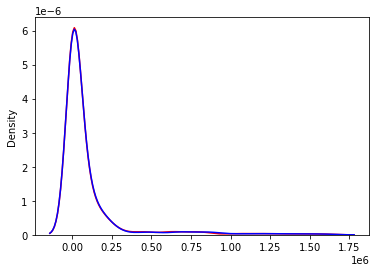

In [ ]:
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)

In [ ]:
# GENERATE TEST FOR US

tmp = res[['submission_date', 'tot_cases']]
tmp['tot_cases'] = pd.to_numeric(tmp['tot_cases'], errors='coerce')

df = tmp.groupby('submission_date', as_index=False).sum()
df

In [ ]:
l = []
for j in range(len(df)):
    if j >= 14:
        l.append(df.iloc[j-14: j, 1].mean())
    else:
        l.append(df.iloc[j,0])
df = df.assign(mean_tot_cases = np.array(l))
df

In [ ]:
rows = df.shape[0]
sof_total = pd.Series([df[df['submission_date'] <= i]['tot_cases'].sum() for i in range(rows)], name='sof_total')

df.set_index('submission_date',inplace = True)
df['sum_of_total'] = sof_total

# move predict col to the end
df = df[ [ col for col in df.columns if col != 'tot_cases' ] + ['tot_cases']]
df

In [ ]:
# get test dataset (last 30 day)
df_test = df.iloc[len(df) - 30:len(df), :]
df_test

In [ ]:
X_test = df_test.iloc[:, [0,1]].values
y_test = df_test.iloc[:, 2].values
y_pred =  model.predict(X_test)
e = y_test - y_pred
mse = np.mean(e**2)
accr = 1 - mse/np.var(y_test)
accr

0.9531226976828786

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


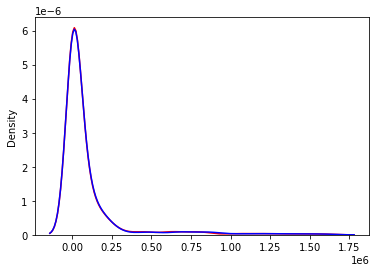

In [ ]:
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)

In [ ]:
list_model = {}
list_accr = {}
for i in states.keys():
  X = states[i].iloc[:, 1].values
  y = states[i].iloc[:, 0].values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,shuffle=False)
  X_train = X_train.reshape(-1, 1)
  X_test = X_test.reshape(-1, 1)
  model = LinearRegression()
  model.fit(X_train, y_train)
  list_model[i] = model

  y_pred =  model.predict(X_test)
  e = y_test - y_pred
  mse = np.mean(e**2)
  accr = 1 - mse/np.var(y_test)
  list_accr[i] = accr

In [ ]:
list_accr

In [ ]:
i='PR'
X = states[i].iloc[:, 1].values
y = states[i].iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,shuffle=False)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
def viz_polymonial():
    plt.scatter(X_train, y_train, color='red')
    plt.plot(X_train, list_model[i].predict(X_train), color='blue')
    plt.xlabel('Day')
    plt.ylabel('Cases')
    plt.show()
    return
viz_polymonial()

In [ ]:

y_pred=list_model[i].predict(X_test)
def viz_polymonial():
    plt.scatter(X_test, y_test, color='red')
    plt.plot(X_test, y_pred, color='blue')
    plt.xlabel('Day')
    plt.ylabel('Cases')
    plt.show()
    return
viz_polymonial()
plt.scatter(X_test, y_test, color='red')

# PCA

In [ ]:
res1 = results_df.copy()
res1 = res1.drop(['created_at', 'consent_cases', 'consent_deaths'], axis = 1)
res1['tot_cases'] = pd.to_numeric(res1['tot_cases'], errors='coerce')
res1.drop(res1[res1['tot_cases'] <= 0].index, inplace=True)
res1.sort_values(['state','submission_date'], ascending=[True,True], inplace=True)
res1 = res1.drop(['submission_date','state'], axis = 1)
res1 = res1.reset_index(drop=True)
cols = res1.columns[res1.dtypes.eq('object')]
res1[cols] = res1[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [ ]:
res1.dropna(inplace=True)

In [ ]:
res1 = res1[ [ col for col in res1.columns if col != 'new_case' ] + ['new_case']]
res1

,tot_cases,tot_death,new_death,pnew_case,conf_death,prob_death,pnew_death,conf_cases,prob_cases,new_case
323,4946,165.0,52.0,0.0,165.0,0.0,0.0,4946.0,0.0,223.0
324,5424,147.0,-18.0,233.0,146.0,1.0,1.0,5191.0,233.0,478.0
325,5668,180.0,33.0,9.0,179.0,1.0,0.0,5426.0,242.0,244.0
326,5831,187.0,7.0,-1.0,186.0,1.0,0.0,5590.0,241.0,163.0
327,6071,198.0,11.0,2.0,197.0,1.0,0.0,5828.0,243.0,240.0
...,...,...,...,...,...,...,...,...,...,...
16592,41488,351.0,0.0,71.0,351.0,0.0,0.0,35818.0,5670.0,129.0
16593,41662,351.0,0.0,10.0,351.0,0.0,0.0,35982.0,5680.0,174.0
16594,42118,351.0,0.0,46.0,351.0,0.0,0.0,36392.0,5726.0,456.0
16595,42379,373.0,22.0,103.0,373.0,0.0,0.0,36550.0,5829.0,261.0


In [ ]:
X = res1.iloc[:, 0:8].values
y = res1.iloc[:, 8].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,shuffle=False)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X_train)
from sklearn.svm import SVR
regressor = SVR(kernel='rbf', epsilon=0.05)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
y_pred = sc_y.inverse_transform(y_pred) 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(principalComponents)
model = LinearRegression()
model.fit(X_poly, y_train)


y_pred =  model.predict(poly_reg.fit_transform(pca.fit_transform(X_test)))
e = y_test - y_pred
mse = np.mean(e**2)
accr = 1 - mse/np.var(y_test)
accr

0.8932276427352925

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


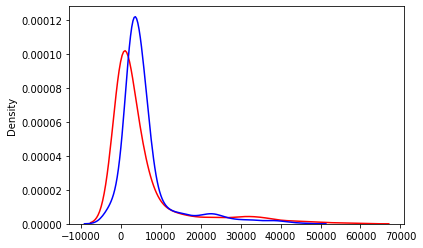

In [ ]:
import seaborn as sns

ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)

In [ ]:

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
y_train = y_train.reshape(-1,1)
y_train = sc_y.fit_transform(y_train)


In [ ]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf', C=1e5, gamma=1e5)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
y_pred = sc_y.inverse_transform(y_pred) 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
e = y_test - y_pred
mse = np.mean(e**2)
accr = 1 - mse/np.var(y_test)
accr

-0.21109861026401888